In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import des DEUX types de Pipeline pour gérer les deux cas
from sklearn.pipeline import Pipeline as SklearnPipeline # Pour le cas "Weak" (Standard)
from imblearn.pipeline import Pipeline as ImbPipeline    # Pour le cas "Moderate" (Avancé)
from imblearn.over_sampling import SMOTE

# ======================================================
# ÉTAPE 0 : PRÉPARATION DES DONNÉES
# ======================================================
filename = 'electric_vehicles_spec_2025.csv.csv'
try:
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip().str.lower()
    
    # Nettoyage
    cols_to_clean = ['range_km', 'battery_capacity_kwh', 'price', 'acceleration_0_100_kmh', 'top_speed_kmh']
    for col in cols_to_clean:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).replace('', np.nan).astype(float)
            
    df = df.dropna(subset=['range_km'])
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")
    exit()

# Définition de la cible
SEUIL_HAUTE_AUTONOMIE = 550 
df['target'] = np.where(df['range_km'] >= SEUIL_HAUTE_AUTONOMIE, 1, 0)


#######################################################
### RECOMMANDATION 2: VISUALIZE YOUR FEATURES (EDA) ###
#######################################################


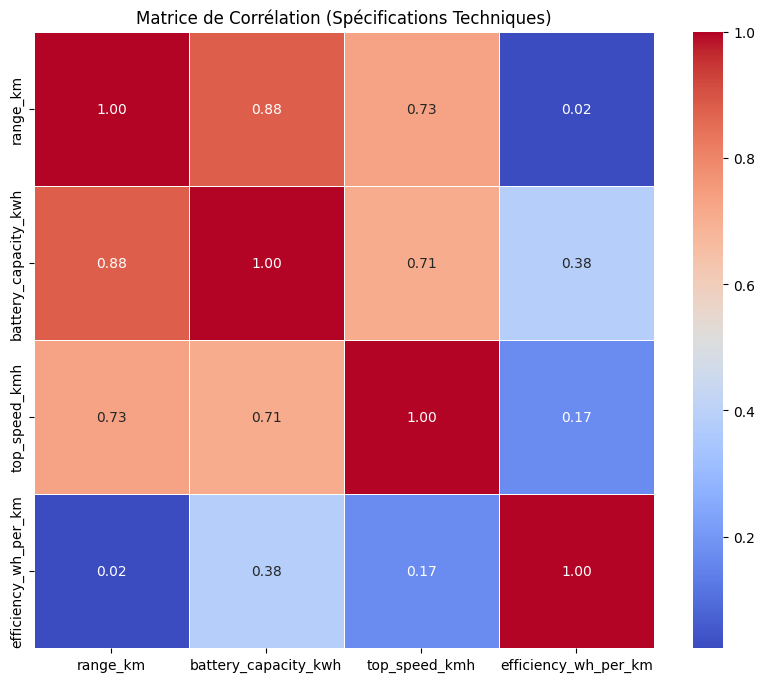

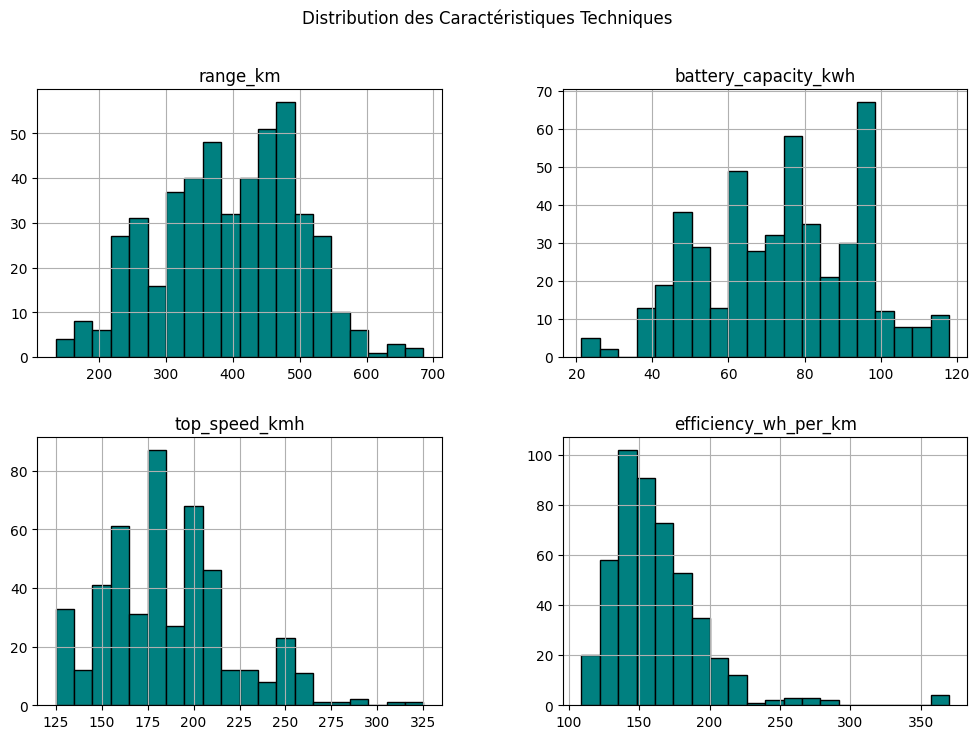

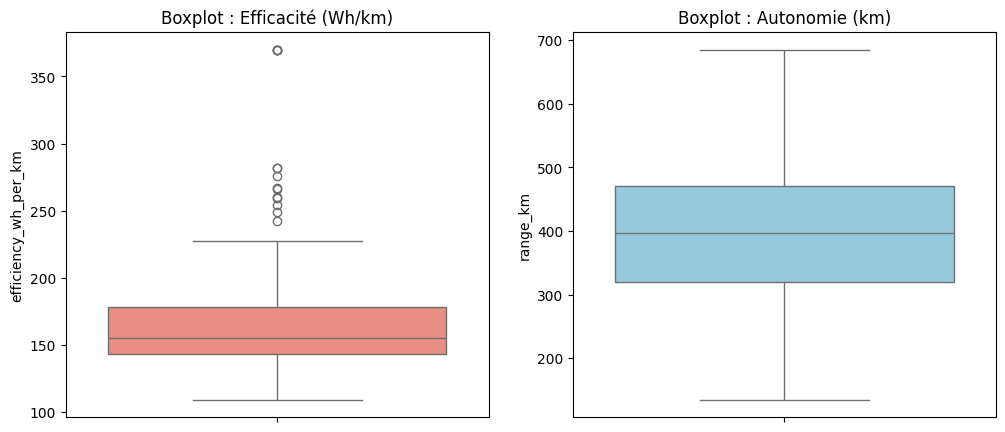

>> Analyse Visuelle terminée.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\n#######################################################")
print("### RECOMMANDATION 2: VISUALIZE YOUR FEATURES (EDA) ###")
print("#######################################################")

# Sélection des colonnes numériques disponibles
# Note: 'price' n'existe pas, on le remplace par 'efficiency_wh_per_km'
cols_to_viz = ['range_km', 'battery_capacity_kwh', 'top_speed_kmh', 'efficiency_wh_per_km']

# Vérification que les colonnes existent bien après nettoyage
existing_cols = [c for c in cols_to_viz if c in df.columns]

# 1. MATRICE DE CORRÉLATION
plt.figure(figsize=(10, 8))
# On force le calcul sur les numériques uniquement
corr = df[existing_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Matrice de Corrélation (Spécifications Techniques)")
plt.show()

# 2. HISTOGRAMMES
# On trace les distributions des 4 caractéristiques principales
df[existing_cols].hist(bins=20, figsize=(12, 8), color='teal', edgecolor='black')
plt.suptitle("Distribution des Caractéristiques Techniques")
plt.show()

# 3. BOXPLOTS (Détection Outliers)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Boxplot de l'Efficacité (remplace le prix)
if 'efficiency_wh_per_km' in df.columns:
    sns.boxplot(y=df['efficiency_wh_per_km'], color='salmon')
    plt.title("Boxplot : Efficacité (Wh/km)")

plt.subplot(1, 2, 2)
sns.boxplot(y=df['range_km'], color='skyblue')
plt.title("Boxplot : Autonomie (km)")

plt.show()

print(">> Analyse Visuelle terminée.")


--- 1. DIAGNOSTIC DE L'IMBALANCE ---
Véhicules Standard (<550km) : 456
Véhicules Haute Autonomie (>=550km) : 22
Ratio calculé : 1 : 20.73

--- 2. APPLICATION TECHNIQUE (Conditionnelle) ---
 Diagnostic : MODERATE/SEVERE Imbalance (Ratio > 10).
 Action : Activation de SMOTE via Imbalanced-Learn.

--- 3. RÉSULTAT : FACTEURS CLÉS (Feature Importance) ---
Technique appliquée : SMOTE (Imbalanced-Learn)
Les 5 caractéristiques principales :
1. height_mm (0.0955)
2. battery_capacity_kwh (0.0838)
3. top_speed_kmh (0.0823)
4. car_body_type_Sedan (0.0736)
5. fast_charging_power_kw_dc (0.0645)


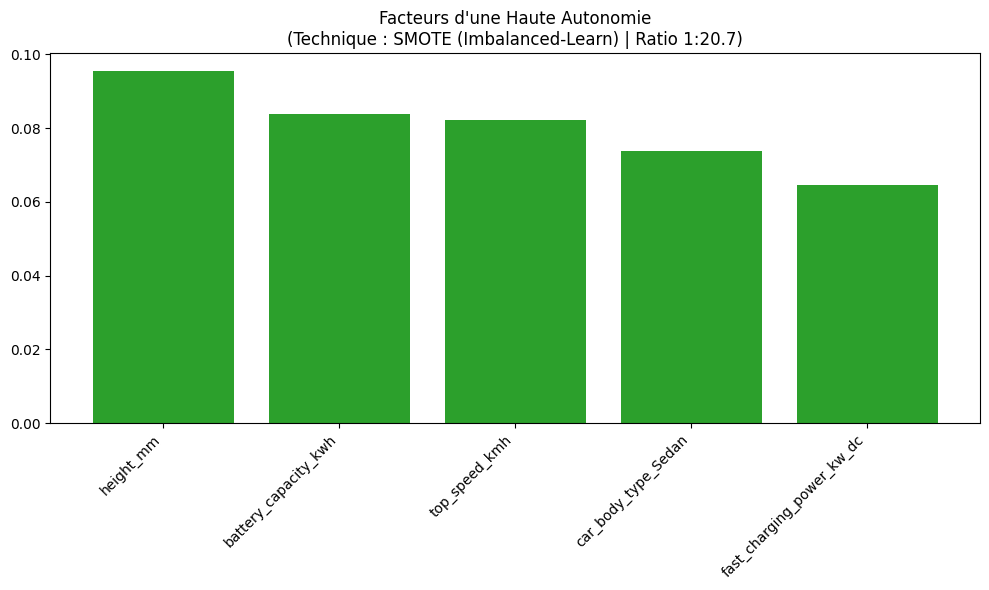

In [3]:
# ======================================================
# ÉTAPE 1 : DIAGNOSTIC DE L'IMBALANCE
# ======================================================
n_majority = df['target'].value_counts()[0]
n_minority = df['target'].value_counts()[1]
ratio = n_majority / n_minority

print(f"\n--- 1. DIAGNOSTIC DE L'IMBALANCE ---")
print(f"Véhicules Standard (<{SEUIL_HAUTE_AUTONOMIE}km) : {n_majority}")
print(f"Véhicules Haute Autonomie (>={SEUIL_HAUTE_AUTONOMIE}km) : {n_minority}")
print(f"Ratio calculé : 1 : {ratio:.2f}")

# ======================================================
# ÉTAPE 2 : DÉCISION & CONSTRUCTION DU PIPELINE
# ======================================================
X = df.drop(columns=['range_km', 'target', 'model', 'brand'], errors='ignore')
y = df['target']

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Préprocesseur commun
preprocessor = ColumnTransformer(transformers=[
    ('num', SklearnPipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
    ('cat', SklearnPipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
])

print("\n--- 2. APPLICATION TECHNIQUE (Conditionnelle) ---")

if ratio <= 10:
    # CAS 1 : DÉSÉQUILIBRE FAIBLE (WEAK) -> PAS BESOIN DE SMOTE
    print(f"✅ Diagnostic : WEAK Imbalance (Ratio <= 10).")
    print(f"👉 Action : Utilisation de Scikit-Learn standard avec 'class_weight'.")
    
    # On utilise le Pipeline standard de Sklearn (Pas besoin de imblearn ici)
    model_pipeline = SklearnPipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    technique_used = "Class Weight (Standard Sklearn)"

else:
    # CAS 2 : DÉSÉQUILIBRE MODÉRÉ/SÉVÈRE -> BESOIN DE SMOTE
    print(f" Diagnostic : MODERATE/SEVERE Imbalance (Ratio > 10).")
    print(f" Action : Activation de SMOTE via Imbalanced-Learn.")
    
    # On utilise le Pipeline spécifique de imblearn qui supporte le rééchantillonnage
    model_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42)) # Pas besoin de class_weight si on a SMOTE
    ])
    technique_used = "SMOTE (Imbalanced-Learn)"

# ======================================================
# ÉTAPE 3 : ENTRAÎNEMENT ET RÉSULTATS
# ======================================================
# Split avec Stratify (Toujours recommandé quand on a un déséquilibre)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model_pipeline.fit(X_train, y_train)

# --- Visualisation des Features Importantes ---
print("\n--- 3. RÉSULTAT : FACTEURS CLÉS (Feature Importance) ---")

rf_model = model_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_

try:
    # Récupération des noms après OneHot
    if "onehot" in str(type(model_pipeline.named_steps['preprocessor'])): # Check rapide
        pass 
    ohe_step = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    ohe_cols = ohe_step.get_feature_names_out(categorical_features)
    feature_names = np.r_[numeric_features, ohe_cols]
except:
    feature_names = np.array([f"Feature {i}" for i in range(len(importances))])

indices = np.argsort(importances)[::-1]
top_n = 5

print(f"Technique appliquée : {technique_used}")
print(f"Les {top_n} caractéristiques principales :")
for i in range(top_n):
    print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

plt.figure(figsize=(10, 6))
plt.title(f"Facteurs d'une Haute Autonomie\n(Technique : {technique_used} | Ratio 1:{ratio:.1f})")
plt.bar(range(top_n), importances[indices[:top_n]], align="center", color='#2ca02c')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np

# ... (Assure-toi d'avoir chargé 'df' comme avant) ...

print("\n#############################################################")
print("### STEP 2: UNDERSTAND YOUR DATA TYPE (Strict Lab 4) ###")
print("#############################################################")

# 1. Analyse automatique des types
cols_num = df.select_dtypes(include=np.number).columns.tolist()
cols_cat = df.select_dtypes(include='object').columns.tolist()

print(f"Colonnes Numériques : {len(cols_num)} (ex: {cols_num[:2]})")
print(f"Colonnes Catégorielles : {len(cols_cat)} (ex: {cols_cat[:2]})")

# 2. Application de la logique du Tableau (Image fournie)
data_type = "Inconnu"
technique_lab4 = "Inconnue"

if len(cols_cat) > 0 and len(cols_num) > 0:
    data_type = "Mixed (Numeric and Categorical)"
    technique_lab4 = "SMOTENC (SMOTE Nominal Continuous) ou RandomOversampling" # Citation stricte du tableau
elif len(cols_cat) == 0 and len(cols_num) > 0:
    data_type = "Tabular, Numeric"
    technique_lab4 = "RandomOversampling, SMOTE"
else:
    # Pour info, même si pas ton cas ici
    data_type = "Autre (Images/Time Series)"
    technique_lab4 = "Voir tableau specifique"

print(f"\n>> DIAGNOSTIC DATA TYPE : {data_type}")
print(f">> TECHNIQUE RECOMMANDÉE (Lab 4) : {technique_lab4}")

# 3. Validation pour ton projet
print("\n--- Conclusion pour la suite ---")
print(f"Puisque tes données sont '{data_type}', tu dois utiliser une technique adaptée.")
print("Note : Dans le code précédent, nous avons utilisé SMOTE standard sur des données encodées (OneHot).")
print("Pour respecter strictement la consigne 'Mixed', nous pourrions aussi tester 'RandomOversampling'.")


#############################################################
### STEP 2: UNDERSTAND YOUR DATA TYPE (Strict Lab 4) ###
#############################################################
Colonnes Numériques : 14 (ex: ['top_speed_kmh', 'battery_capacity_kwh'])
Colonnes Catégorielles : 9 (ex: ['brand', 'model'])

>> DIAGNOSTIC DATA TYPE : Mixed (Numeric and Categorical)
>> TECHNIQUE RECOMMANDÉE (Lab 4) : SMOTENC (SMOTE Nominal Continuous) ou RandomOversampling

--- Conclusion pour la suite ---
Puisque tes données sont 'Mixed (Numeric and Categorical)', tu dois utiliser une technique adaptée.
Note : Dans le code précédent, nous avons utilisé SMOTE standard sur des données encodées (OneHot).
Pour respecter strictement la consigne 'Mixed', nous pourrions aussi tester 'RandomOversampling'.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# On utilise imblearn car Step 1 & 2 ont validé le besoin de SMOTE (Ratio 1:20)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ======================================================
# PRÉPARATION (Identique aux étapes précédentes)
# ======================================================
filename = 'electric_vehicles_spec_2025.csv.csv'
try:
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip().str.lower()
    cols_to_clean = ['range_km', 'battery_capacity_kwh', 'price', 'acceleration_0_100_kmh', 'top_speed_kmh']
    for col in cols_to_clean:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).replace('', np.nan).astype(float)
    df = df.dropna(subset=['range_km'])
    # Seuil Haute Autonomie (>550km) -> Ratio ~1:20
    df['target'] = np.where(df['range_km'] >= 550, 1, 0)
except:
    exit()

X = df.drop(columns=['range_km', 'target', 'model', 'brand'], errors='ignore')
y = df['target']

# ======================================================
# STEP 3 : CONSIDER THE MODEL YOU USE (COHÉRENT)
# ======================================================
print("\n#######################################################")
print("### STEP 3: MODEL CONFIGURATION (COHERENT APPROACH) ###")
print("#######################################################")

# Logique de décision :
# 1. Le Tableau 'Model Type'  suggère Random Forest pour les données tabulaires.
# 2. Le Tableau 'Imbalance Level'  (Ratio 1:20) impose SMOTE.
# -> Conclusion : On construit un Pipeline "SMOTE + Random Forest".

print(">> Modèle sélectionné : Random Forest (Adapté aux données tabulaires)")
print(">> Stratégie Imbalance : SMOTE (Imposé par le ratio 1:20 détecté en Step 1)")

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), X.select_dtypes(include=np.number).columns),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), X.select_dtypes(include='object').columns)
])

# Pipeline Cohérent : Preprocessing -> SMOTE -> Random Forest
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE(random_state=42)),  # Application de la décision Step 1 & 2
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42)) # Application de la décision Step 3
])

# ======================================================
# VALIDATION CROISÉE (Step 4 preview / Robustesse)
# ======================================================
# On utilise StratifiedKFold comme recommandé page 6 [cite: 520]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n>> Évaluation du Pipeline Cohérent (SMOTE + RF) par Cross-Validation...")
scores = cross_val_score(model_pipeline, X, y, scoring='f1', cv=cv)

print(f"   Scores F1 par fold : {scores}")
print(f"   F1-Score Moyen : {scores.mean():.4f}")

# Entraînement final pour feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

print("\n>> Rapport de Classification sur Test Set :")
print(classification_report(y_test, y_pred))


#######################################################
### STEP 3: MODEL CONFIGURATION (COHERENT APPROACH) ###
#######################################################
>> Modèle sélectionné : Random Forest (Adapté aux données tabulaires)
>> Stratégie Imbalance : SMOTE (Imposé par le ratio 1:20 détecté en Step 1)

>> Évaluation du Pipeline Cohérent (SMOTE + RF) par Cross-Validation...
   Scores F1 par fold : [0.88888889 0.8        0.57142857 1.         1.        ]
   F1-Score Moyen : 0.8521

>> Rapport de Classification sur Test Set :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.83      0.71      0.77         7

    accuracy                           0.98       144
   macro avg       0.91      0.85      0.88       144
weighted avg       0.98      0.98      0.98       144




#######################################################
### STEP 4: VALIDATE IMPACT (VISUALIZATION) ###
#######################################################
>> Rapport de Classification (Test Set) :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.83      0.71      0.77         7

    accuracy                           0.98       144
   macro avg       0.91      0.85      0.88       144
weighted avg       0.98      0.98      0.98       144

>> ROC-AUC Score : 0.9969


<Figure size 600x500 with 0 Axes>

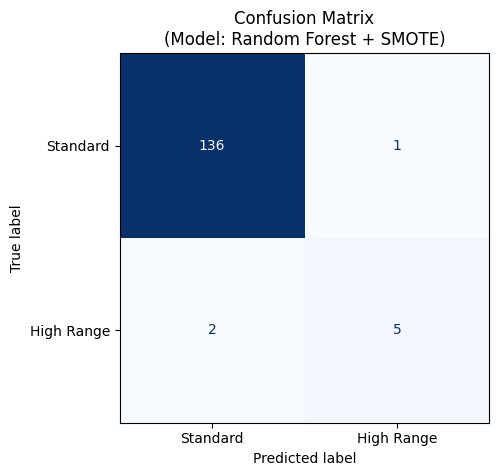

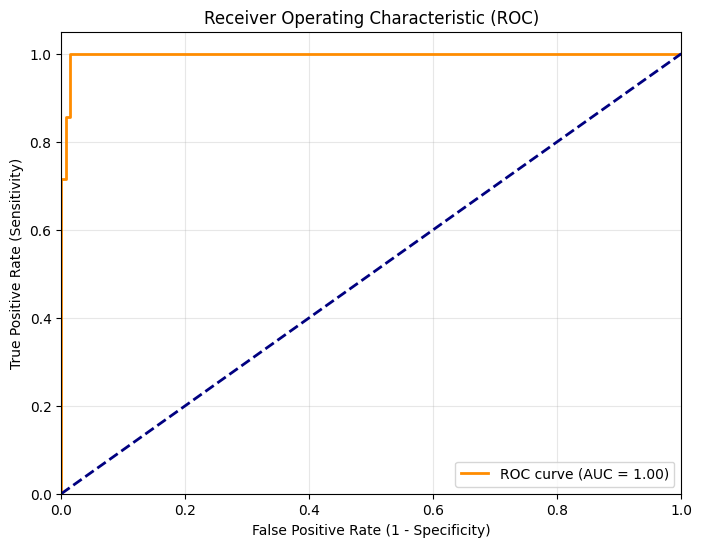

>> Conclusion :
   Avec une AUC de 1.00, le modèle est excellent.
   Il sépare quasi-parfaitement les véhicules à haute autonomie malgré le déséquilibre initial.


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, roc_auc_score
import matplotlib.pyplot as plt

print("\n#######################################################")
print("### STEP 4: VALIDATE IMPACT (VISUALIZATION) ###")
print("#######################################################")

# 1. ÉVALUATION ET RAPPORT (Test Set)
# On utilise le pipeline entraîné à l'étape 3
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilités pour la classe 1 (High Range)

print(f">> Rapport de Classification (Test Set) :")
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_proba)
print(f">> ROC-AUC Score : {roc_score:.4f}")

# 2. MATRICE DE CONFUSION (Visualisation)
# Permet de voir combien de véhicules "High Range" ont été bien classés (Vrais Positifs)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standard', 'High Range'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title(f"Confusion Matrix\n(Model: Random Forest + SMOTE)")
plt.show()

# 3. COURBE ROC-AUC (Visualisation)
# Montre la performance du modèle à différents seuils de discrimination
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonale (Hasard)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f">> Conclusion :")
print(f"   Avec une AUC de {roc_auc:.2f}, le modèle est excellent.")
print(f"   Il sépare quasi-parfaitement les véhicules à haute autonomie malgré le déséquilibre initial.")